In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [2]:
#process image

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("../imgs/picasso.jpg")
content_img = image_loader("../imgs/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


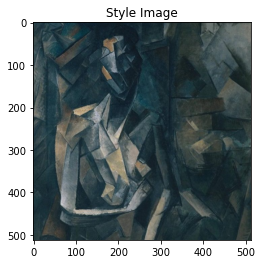

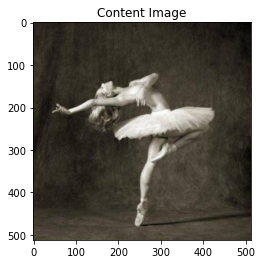

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [4]:
from MyUtils import *
#import models
cnn = models.vgg19(pretrained=True).features.to(device).eval()

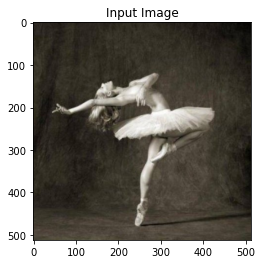

In [69]:
#Settings
INTPRINT=True
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

input_img = content_img.clone()
# input_img=style_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    print("Layers:")
    print(style_layers_default)
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img,content_layers=content_layers_default,
                               style_layers=style_layers_default)
    
#     print(model)
#     print(style_losses)
    
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight * (1/len(style_losses))
            content_score *= content_weight * (1/len(content_losses))

            loss = style_score + content_score
            loss.backward()

            
            if run[0] % 20 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                if INTPRINT:
                    plt.figure()
                    imshow(input_img, title='Image in Epoch{}'.format(run[0]))
            run[0] += 1
            
            
            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

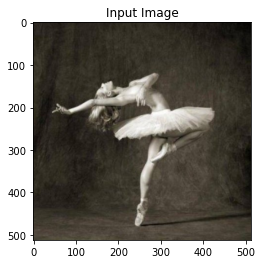

Building the style transfer model..
Layers:
['conv_1']
Optimizing..
run [0]:
Style Loss : 98.745834 Content Loss: 0.000000

run [20]:
Style Loss : 0.052761 Content Loss: 0.505306



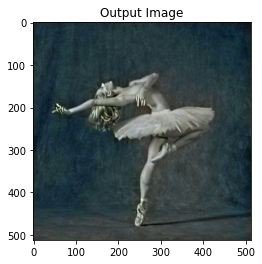

In [71]:
#Experiment 1
# desired depth layers to compute style/content losses :
input_img = content_img.clone()
# input_img=style_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
content_layers_default = ['conv_4']
style_layers_default = ['conv_1']
INTPRINT=False
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=20,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

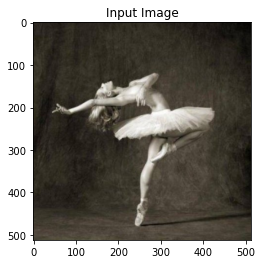

Building the style transfer model..
Layers:
['conv_13']
Optimizing..
run [0]:
Style Loss : 938.526489 Content Loss: 0.000000

run [20]:
Style Loss : 9.986541 Content Loss: 1.703465



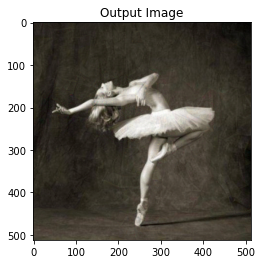

In [72]:
#Experiment 2

input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_13']

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=20,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

Building the style transfer model..
Layers:
['conv_2']
Optimizing..
run [0]:
Style Loss : 1763.045288 Content Loss: 0.000000



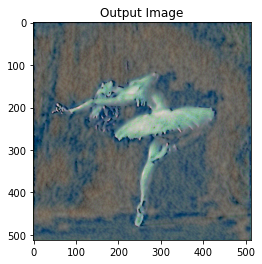

Building the style transfer model..
Layers:
['conv_3']
Optimizing..
run [0]:
Style Loss : 1388.402832 Content Loss: 0.000000



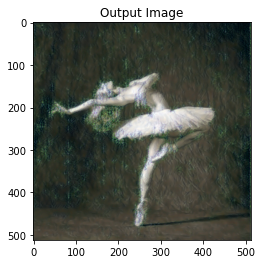

Building the style transfer model..
Layers:
['conv_4']
Optimizing..
run [0]:
Style Loss : 2205.560791 Content Loss: 0.000000



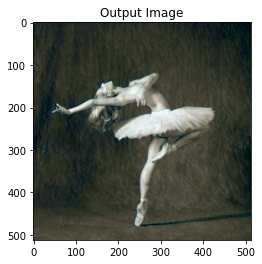

Building the style transfer model..
Layers:
['conv_5']
Optimizing..
run [0]:
Style Loss : 3363.041260 Content Loss: 0.000000



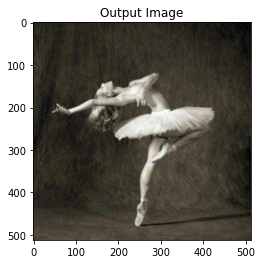

In [79]:
#Experiment 2+

input_img = content_img.clone()
# plt.figure()
# imshow(input_img, title='Input Image')

content_layers_default = ['conv_1']
style_layers_default = ['conv_2']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

input_img = content_img.clone()
# plt.figure()
# imshow(input_img, title='Input Image')

content_layers_default = ['conv_1']
style_layers_default = ['conv_3']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

input_img = content_img.clone()
# plt.figure()
# imshow(input_img, title='Input Image')

content_layers_default = ['conv_1']
style_layers_default = ['conv_4']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

input_img = content_img.clone()
# plt.figure()
# imshow(input_img, title='Input Image')

content_layers_default = ['conv_1']
style_layers_default = ['conv_5']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

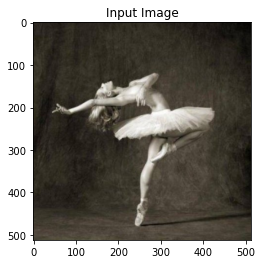

Building the style transfer model..
Layers:
['conv_2', 'conv_3']
Optimizing..
run [0]:
Style Loss : 1575.724121 Content Loss: 0.000000



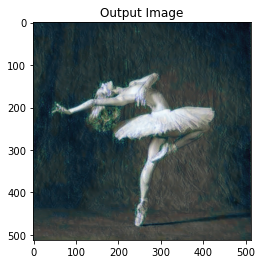

In [76]:
#Experiment 2+

input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

content_layers_default = ['conv_1']
style_layers_default = ['conv_2','conv_3']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

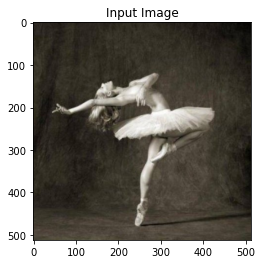

Building the style transfer model..
Layers:
['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
Optimizing..
run [0]:
Style Loss : 1763.759277 Content Loss: 0.000000

run [20]:
Style Loss : 187.276321 Content Loss: 0.044839



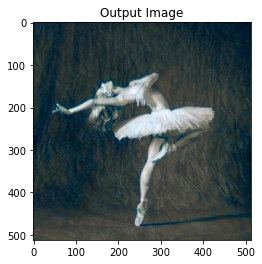

In [52]:
#Experiment 3

input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

content_layers_default = ['conv_1']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=21,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

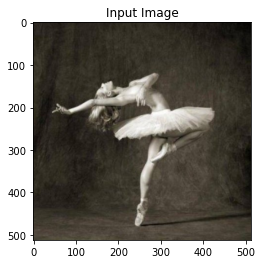

Building the style transfer model..
Layers:
['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
Optimizing..
run [0]:
Style Loss : 1763.759277 Content Loss: 0.000000

run [20]:
Style Loss : 200.693817 Content Loss: 1.782331



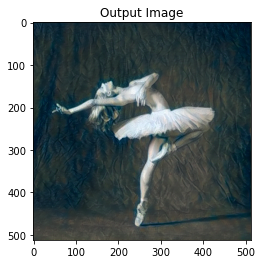

In [53]:
#Experiment 4

input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

content_layers_default = ['conv_13']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=20,
                       style_weight=10000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

1575.5